VERSION 2: INPUT AS N ONE-HOT VECTORS

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
min_transactions = 200

N = 25 #number of pre-transactions used for predict

num_of_items = 57
time_slot = 24*60*60*100 #1 day
time_slot

8640000

In [4]:
RAWDATA_PATH = '/content/gdrive/MyDrive/NCKH/Multi-LayerPerceptron/rawdata.csv'
HASH_FILE_PATH = '/content/gdrive/MyDrive/NCKH/Multi-LayerPerceptron/hash_table.csv'
# NEW_DATA_PATH = '/content/gdrive/MyDrive/Timeseries/UserMoreThan200Trans.csv'
WEIGHTS_PATH = '/content/gdrive/MyDrive/NCKH/Multi-LayerPerceptron/mlp_v2.hdf5'

In [5]:
# load proceessed data
# df = pd.read_csv(NEW_DATA_PATH)
df_hash = pd.read_csv(HASH_FILE_PATH)

temp = zip(df_hash.itemID,df_hash.hash_value)
hash_itemID = dict(temp)

temp = zip(df_hash.hash_value,df_hash.itemID)
reverse_hash_itemID = dict(temp)

# Prepare data

Note: Ignore "Load data", "Ignore user" if you use processed data

## Load data, convert to dataframe

In [6]:
df = pd.read_csv(RAWDATA_PATH)
df.head()

,timestamp,userID,itemID
0,1604163797349,eed56d467112a57bbad058399b9c146410221,122
1,1604164215912,488f41e8995c2d6f5069eb46f723ee8710221,113
2,1604164499407,82e3bc40fbaf250d546b4e4de6bdb3aa10221,101
3,1604164521426,82e3bc40fbaf250d546b4e4de6bdb3aa10221,106
4,1604164654112,488f41e8995c2d6f5069eb46f723ee8710221,26


In [7]:
hash_itemID = {}
idx = 0
for itemID in set(df.itemID):
  hash_itemID[itemID] = idx
  idx += 1

In [8]:
with open(HASH_FILE_PATH,'w') as f:
  f.write('itemID,hash_value\n')
  for item in hash_itemID:
    f.write(f'{item},{hash_itemID[item]}\n')

In [9]:
reverse_hash_itemID = {hash_itemID[i]:i for i in hash_itemID}

## Ignore user has less transactions

In [10]:
from google.colab import output

In [11]:
len(df), len(list(set(df.userID)))

(84902, 306)

In [12]:
lst_user = list(set(df.userID))

new_df = pd.DataFrame(columns=df.columns)
idx = 0
for userID in lst_user:
  print(f'{idx}/{len(lst_user)}')
  idx += 1
  subdf = df[df.userID == userID]
  if len(subdf) > min_transactions: new_df = new_df.append(subdf, ignore_index=True)
  output.clear()

lst_user = list(set(new_df.userID)) #re-assign lst_user

In [13]:
# len(new_df),len(list(set(new_df.userID)))

len(lst_user)

306

In [14]:
df = new_df.sort_values(by='timestamp')
df = df.reset_index(drop=True)
df

,timestamp,userID,itemID
0,1604163797349,eed56d467112a57bbad058399b9c146410221,122
1,1604164215912,488f41e8995c2d6f5069eb46f723ee8710221,113
2,1604164499407,82e3bc40fbaf250d546b4e4de6bdb3aa10221,101
3,1604164521426,82e3bc40fbaf250d546b4e4de6bdb3aa10221,106
4,1604164654112,488f41e8995c2d6f5069eb46f723ee8710221,26
...,...,...,...
84897,1619801123715,3fe32324b910330aa272d747e1e2491610221,101
84898,1619801333120,36b7fa8458ab24566e7f2a5d3160b9ec10221,101
84899,1619801540282,e4649e124f01e623dd240562a11a989810221,61
84900,1619801886094,48d73dd062c7e7417d82fd5c5da4517f10221,21


In [15]:
# df.to_csv(NEW_DATA_PATH,index=False)

## Find time slot

In [16]:
# time_slot = -1
# for userID in lst_user:
#   subdf = df[df.userID == userID]
#   times = subdf.timestamp.tolist()
#   new_value = min([times[x]-times[x-1] for x in range(1,len(times))],default=-1)
#   if new_value < time_slot or time_slot == -1:
#     time_slot = new_value

# time_slot

## Generate time series data

In [17]:
import math

start_time = min(df.timestamp)
end_time = max(df.timestamp)
num_of_slots = math.ceil((end_time-start_time)/time_slot)
start_time,end_time,num_of_slots

(1604163797349, 1619801952751, 1810)

### example

In [18]:
userID = 'eed56d467112a57bbad058399b9c146410221'
subdf = df[df.userID == userID]
subdf

,timestamp,userID,itemID
0,1604163797349,eed56d467112a57bbad058399b9c146410221,122
40,1604180842140,eed56d467112a57bbad058399b9c146410221,101
689,1604319498998,eed56d467112a57bbad058399b9c146410221,5
716,1604324486866,eed56d467112a57bbad058399b9c146410221,122
852,1604361560049,eed56d467112a57bbad058399b9c146410221,122
...,...,...,...
83635,1619586629446,eed56d467112a57bbad058399b9c146410221,26
83636,1619586758395,eed56d467112a57bbad058399b9c146410221,106
83777,1619605764963,eed56d467112a57bbad058399b9c146410221,122
84582,1619747121675,eed56d467112a57bbad058399b9c146410221,63


In [19]:
series = np.zeros((num_of_slots,num_of_items))
count = [0]*num_of_slots
lst_time = subdf.timestamp.tolist()
lst_itemID = subdf.itemID.tolist()
for time,itemID in zip(lst_time,lst_itemID):
  idx = (time-start_time) // time_slot
  series[idx][hash_itemID[itemID]] = 1
  count[idx] += 1

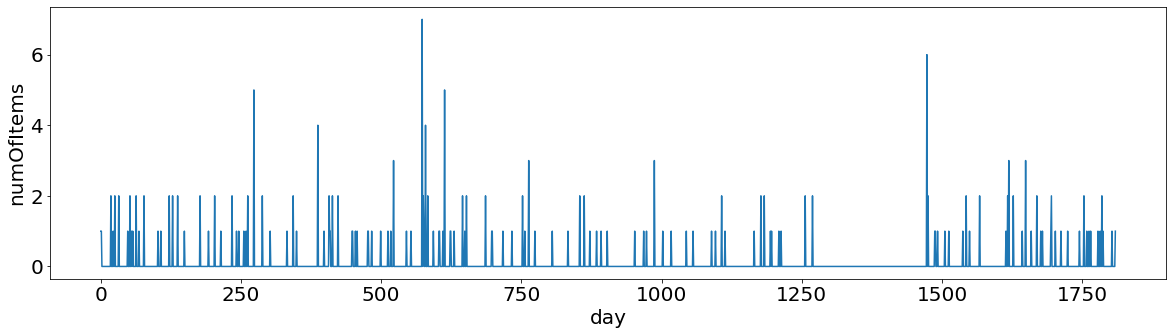

In [20]:
plt.figure(figsize=(20,5))
plt.rc('font', size=20) 
plt.plot(range(len(count)),count)
plt.xlabel('day',fontsize=20)
plt.ylabel('numOfItems',fontsize=20)
plt.show()

In [21]:
history = list(map(lambda x: hash_itemID[x],subdf.itemID.tolist()))
print(*history,sep=' ')

55 41 4 55 55 55 55 1 21 21 20 7 0 31 6 21 29 29 30 15 31 20 30 29 30 6 21 21 30 30 20 6 21 3 41 45 41 3 47 41 20 41 6 41 2 1 21 21 0 44 20 6 7 21 29 29 30 29 30 29 30 30 20 6 0 1 2 30 21 3 30 20 4 6 5 30 55 30 54 55 22 6 19 23 41 45 55 30 55 55 30 55 55 56 54 30 41 55 41 41 55 55 41 17 18 9 21 9 6 55 55 55 55 7 30 31 29 6 29 30 1 30 30 30 6 9 17 30 29 6 41 45 41 44 41 41 41 6 7 30 6 29 29 29 16 30 6 0 30 30 1 2 6 55 41 45 41 6 41 55 41 41 7 6 29 29 41 45 6 0 1 2 29 3 41 30 41 41 41 4 6 7 5 31 29 6 29 30 44 30 0 19 23 30 30 30 22 31 30 30 6 30 55 55 55 55 22 55 41 41 6 1 41 0 41 41 22 45 55 30 30


In [22]:
import more_itertools as mit
X_idx = np.array(list(mit.windowed(history, n=N, step=1)))[:-1]
y = history[N:]

In [23]:
X = []
for x in X_idx:
  new_record = [0]*num_of_items
  new_record[x[0]] = 1
  new_record[x[1]] = 1
  new_record[x[2]] = 1
  X.append(new_record)
X = np.array(X)

### generate

In [24]:
lst_user = list(set(df.userID))
len(lst_user)

306

In [25]:
import more_itertools as mit
from google.colab import output
X_idx = []
y = []

def onehot(x):
  #x: int
  lst = [0]*num_of_items
  lst[x] = 1
  return lst

for userID in lst_user:
  subdf = df[df.userID == userID]
  history = list(map(lambda x: hash_itemID[x],subdf.itemID.tolist()))
  X_idx.extend(list(mit.windowed(history, n=N, step=1))[:-1])
  y.extend(list(map(onehot,history[N:])))

X_idx = np.array(X_idx)
y = np.array(y)

# Version 2: input as Nx57 vector + flatten

In [26]:
X = []
for x in X_idx:
  new_record = []
  for i in range(N):
    temp = [0]*num_of_items
    temp[x[i]] = 1
    new_record.extend(temp) #flatten
  X.append(new_record)
X = np.array(X)

In [27]:
X.shape

(77252, 1425)

#### split train-test

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [29]:
X_train[0],y_train[0]

(array([0, 0, 0, ..., 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]))

In [30]:
X_train.shape

(54076, 1425)

# MLP

In [31]:
import numpy as np 
import os
import numpy as np
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras

model = Sequential()

model.add(Dense(128,input_shape=(N*num_of_items,), activation= 'relu'))

model.add(Dense(57, activation='softmax'))

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               182528    
_________________________________________________________________
dense_1 (Dense)              (None, 57)                7353      
Total params: 189,881
Trainable params: 189,881
Non-trainable params: 0
_________________________________________________________________


In [32]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
model_checkpoint = ModelCheckpoint(WEIGHTS_PATH, monitor='loss', save_best_only=True, save_feq='epoch')
early_stop = EarlyStopping(verbose=True, patience=5, monitor='loss')
model.fit(X_train,y_train,batch_size=8,epochs=1000,verbose=True, callbacks=[early_stop, model_checkpoint])

Epoch 1/1000
6760/6760 [==============================] - 12s 2ms/step - loss: 2.0320 - accuracy: 0.4604
Epoch 2/1000
6760/6760 [==============================] - 11s 2ms/step - loss: 1.7633 - accuracy: 0.5116
Epoch 3/1000
6760/6760 [==============================] - 11s 2ms/step - loss: 1.6133 - accuracy: 0.5399
Epoch 4/1000
6760/6760 [==============================] - 11s 2ms/step - loss: 1.4766 - accuracy: 0.5706
Epoch 5/1000
6760/6760 [==============================] - 11s 2ms/step - loss: 1.3479 - accuracy: 0.6017
Epoch 6/1000
6760/6760 [==============================] - 11s 2ms/step - loss: 1.2334 - accuracy: 0.6311
Epoch 7/1000
6760/6760 [==============================] - 11s 2ms/step - loss: 1.1310 - accuracy: 0.6589
Epoch 8/1000
6760/6760 [==============================] - 11s 2ms/step - loss: 1.0398 - accuracy: 0.6842
Epoch 9/1000
6760/6760 [==============================] - 11s 2ms/step - loss: 0.9576 - accuracy: 0.7089
Epoch 10/1000
6760/6760 [==============================

In [33]:
def post_process(x):
  idx = x.argsort()[-1:-6:-1]
  return list(zip(idx,x[idx]))

In [34]:
y_preds = model.predict(X_test)
print(y_preds[1])
y_preds = np.array(list(map(post_process,y_preds)))


[1.18448511e-14 2.86777789e-11 1.74705580e-11 7.52464757e-09
 6.42963738e-11 1.59353837e-24 8.07326213e-16 2.66137688e-15
 0.00000000e+00 8.54736067e-22 4.13063063e-23 0.00000000e+00
 4.04938564e-34 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.70687094e-28 1.27029786e-35 5.87928125e-23
 1.08243588e-19 5.14987615e-16 2.56558881e-23 8.82967365e-33
 2.33034750e-27 3.95808334e-36 1.92637734e-27 0.00000000e+00
 0.00000000e+00 4.00306778e-17 1.55735458e-09 1.20501765e-20
 4.55336282e-36 0.00000000e+00 5.37204680e-31 1.49957860e-33
 0.00000000e+00 7.46939827e-23 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.44252347e-15 3.85834090e-33 1.74661293e-37
 0.00000000e+00 1.88768912e-22 0.00000000e+00 2.91138730e-31
 0.00000000e+00 0.00000000e+00 0.00000000e+00 1.80211142e-37
 0.00000000e+00 0.00000000e+00 9.24170962e-25 1.22263535e-21
 1.00000000e+00]


In [35]:
y_preds = model.predict(X_test)
y_preds = np.array(list(map(post_process,y_preds)))
acc = 0
for y_true, y_pred in zip(y_test,y_preds):
  key = np.argmax(y_true)
  if key in y_pred: acc += 1

acc/len(y_test)

0.6802295478080773

In [36]:
#wrapper
def process(x):
  #x: array/ndarray of N item

  # inp = np.array(list(map(lambda t: hash_itemID[t],x)))
  inp = np.zeros(N*num_of_items,)
  for i in range(N): inp[num_of_items*i + hash_itemID[x[i]]] = 1
  y_pred = model.predict(np.array([inp]))
  y_pred = post_process(y_pred[0])
  out = list(map(lambda t: (reverse_hash_itemID[t[0]],t[1]),y_pred))

  return out

## Infer

In [37]:
process([101,106,7])

IndexError: ignored